# Imports

In [3]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install transformers
# !pip install ipywidgets
# !pip install xgboost
# !pip install seaborn
# !pip install statsmodels
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Explore Data

Ratio of Spam vs Not Spam messages:
Not Spam: 86.59%
Spam: 13.41%


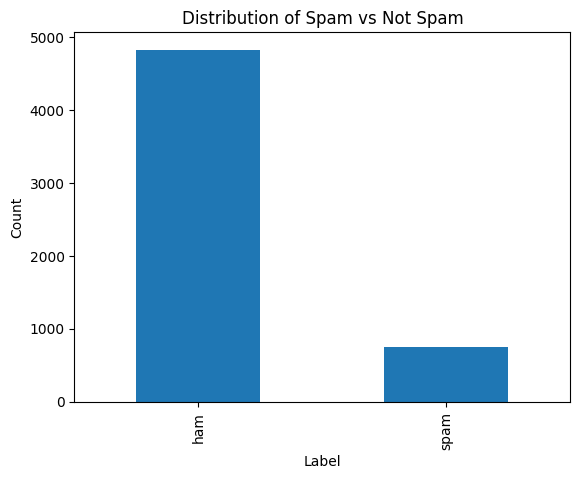

Total Messages: 5572
Average Length of Messages: 80.11880832735105


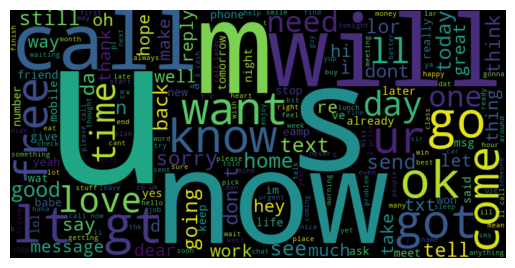

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1') # Use latin-1 to deal wuth unknown characters in ACSII
df = df[['v1','v2']]

# To ensure we are considering "ExAmpLe" is the same word as "example"
def clean_text(text):
    text = text.lower()
    return "".join([ch if ch.isalnum() else " " for ch in text])

df['v2'] = df['v2'].apply(clean_text)

# Calculate the ratio of Not Spam messages
not_spam_ratio = (df[df['v1'] == 'ham'].count() / len(df)) * 100
spam_ratio = (df[df['v1'] == 'spam'].count() / len(df)) * 100

# Print statement with formatted output
print(f"Ratio of Spam vs Not Spam messages:\nNot Spam: {not_spam_ratio['v1']:.2f}%\nSpam: {spam_ratio['v1']:.2f}%")
df['v1'].value_counts().plot(kind='bar')
plt.title('Distribution of Spam vs Not Spam')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Test Stats
print("Total Messages:", len(df))
print("Average Length of Messages:", df['v2'].str.len().mean())
# print("Unique Words:", df['v2'].str.split(expand=True).stack().nunique())

# Word frequency 
all_words = ' '.join(df['v2'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can notice that the dataset we are using is very imbalanced, which is something that we need to take into account when building our models

# Set Up Data

In [3]:
df.rename(columns={'v1':'label','v2':'text'}, inplace=True)

# ham = not spam = 0, spam = 1
mapping = {'ham': 0, 'spam': 1}
# Apply mapping
df['encoded_label'] = df['label'].map(mapping)

# Create variables
texts = df['text']
labels = df['encoded_label']

# Train test split for evaluation
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Classic machine learning - TF-IDF 

In [ ]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_TFIDF = tfidf.fit_transform(X_train_text).toarray()
X_test_TFIDF = tfidf.transform(X_test_text).toarray()

# Models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

clfs = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
results_grid = {}

for name, model in clfs.items():
    print(f"Running GridSearch for {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='precision',   # focus on precision due to class imbalance
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_TFIDF, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_TFIDF)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}\n")
    
    results_grid[name] = {
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec
    }
print(results_grid)

results = {}

Running GridSearch for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9874, Precision: 0.9787

Running GridSearch for Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5}
Accuracy: 0.9363, Precision: 0.7216

Running GridSearch for XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.9731, Precision: 0.9837

Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.9758, Precision: 0.9919

{'Logistic Regression': {'best_params': {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lib


===== Logistic Regression =====
Accuracy: 0.9713004484304932
Precision: 0.9834710743801653


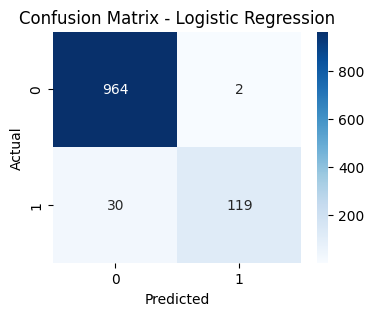


===== Decision Tree =====
Accuracy: 0.9704035874439462
Precision: 0.9833333333333333


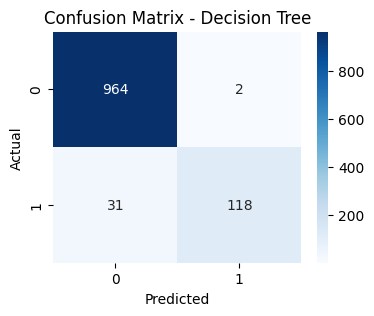


===== XGBoost =====
Accuracy: 0.9713004484304932
Precision: 0.9834710743801653


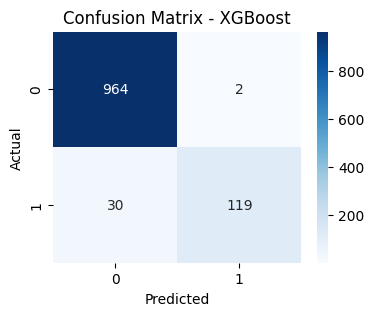


===== Gradient Boosting =====
Accuracy: 0.9704035874439462
Precision: 0.9833333333333333


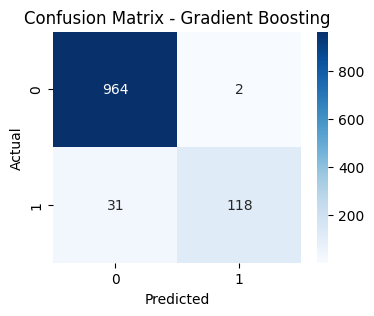

{'Logistic Regression': {'accuracy': 0.9713004484304932,
  'precision': 0.9834710743801653},
 'Decision Tree': {'accuracy': 0.9704035874439462,
  'precision': 0.9833333333333333},
 'XGBoost': {'accuracy': 0.9713004484304932, 'precision': 0.9834710743801653},
 'Gradient Boosting': {'accuracy': 0.9704035874439462,
  'precision': 0.9833333333333333}}

In [7]:
final_model_params = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=10, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10,class_weight='balanced', min_samples_split=5, random_state=42),
    'XGBoost': XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=42)
}
for name, final_model_params in clfs.items():
    model.fit(X_train_TFIDF, y_train)
    y_pred = model.predict(X_test_TFIDF)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results[name] = {"accuracy": acc, "precision": prec}

results

# Bert Model

In [9]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
train_tokens = X_train_text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
test_tokens  = X_test_text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

model = model_class.from_pretrained(pretrained_weights)

## Prepare Dataset
- tokenizing the dataset
- padding the tokens
- tell model to ignore the padded values (aka masking)

In [10]:
# Determine max length across both sets
max_len = max(train_tokens.apply(len).max(), test_tokens.apply(len).max())

# Pad sequences
train_padded = np.array([t + [0]*(max_len - len(t)) for t in train_tokens])
test_padded  = np.array([t + [0]*(max_len - len(t)) for t in test_tokens])

# Create attention masks
train_attention_mask = np.where(train_padded != 0, 1, 0)
test_attention_mask  = np.where(test_padded != 0, 1, 0)

print("Train padded shape:", train_padded.shape)
print("Test padded shape:", test_padded.shape)
print("Train attention mask shape:", train_attention_mask.shape)
print("Test attention mask shape:", test_attention_mask.shape)

Train padded shape: (4457, 199)
Test padded shape: (1115, 199)
Train attention mask shape: (4457, 199)
Test attention mask shape: (1115, 199)


## Using Bert

In [11]:
# Convert train/test padded sequences to torch tensors
train_input_ids = torch.tensor(train_padded)
train_attention_mask = torch.tensor(train_attention_mask)

test_input_ids = torch.tensor(test_padded)
test_attention_mask = torch.tensor(test_attention_mask)

# Extract features from BERT (CLS token)
with torch.no_grad():
    train_outputs = model(train_input_ids, attention_mask=train_attention_mask)
    test_outputs  = model(test_input_ids, attention_mask=test_attention_mask)

# CLS token features
train_features = train_outputs.last_hidden_state[:, 0, :].numpy()
test_features  = test_outputs.last_hidden_state[:, 0, :].numpy()


===== Logistic Regression =====
Accuracy: 0.9865470852017937
Precision: 0.9466666666666667


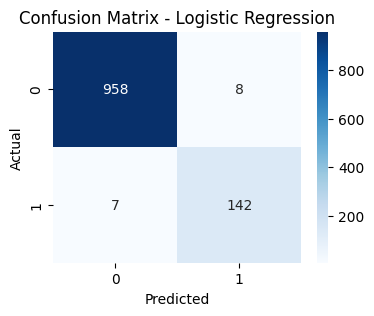


===== Decision Tree =====
Accuracy: 0.9551569506726457
Precision: 0.7734806629834254


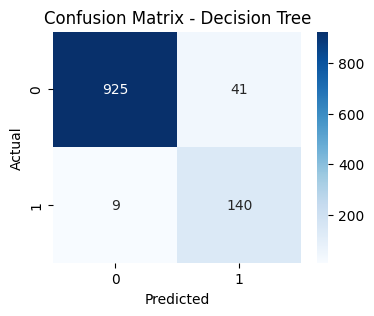


===== XGBoost =====
Accuracy: 0.9910313901345291
Precision: 0.986013986013986


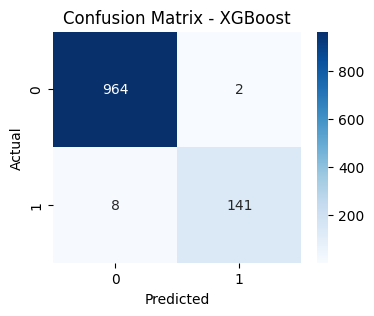


===== Gradient Boosting =====
Accuracy: 0.9856502242152466
Precision: 0.965034965034965


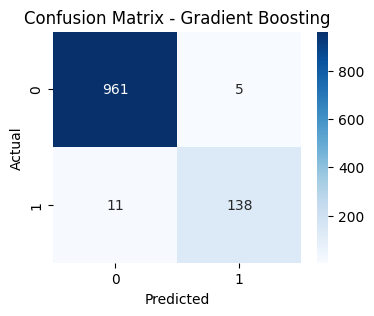

{'Logistic Regression': {'accuracy': 0.9865470852017937,
  'precision': 0.9466666666666667},
 'Decision Tree': {'accuracy': 0.9551569506726457,
  'precision': 0.7734806629834254},
 'XGBoost': {'accuracy': 0.9910313901345291, 'precision': 0.986013986013986},
 'Gradient Boosting': {'accuracy': 0.9856502242152466,
  'precision': 0.965034965034965}}

In [12]:
bert_models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5,class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss"),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_bert = {}

for name, model in bert_models.items():

    # Train on full train set
    model.fit(train_features, y_train)

    # Predict on test set
    y_pred = model.predict(test_features)

    # Metrics
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)

    # Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save results
    results_bert[name] = {
        "accuracy": acc,
        "precision": prec
    }

results_bert


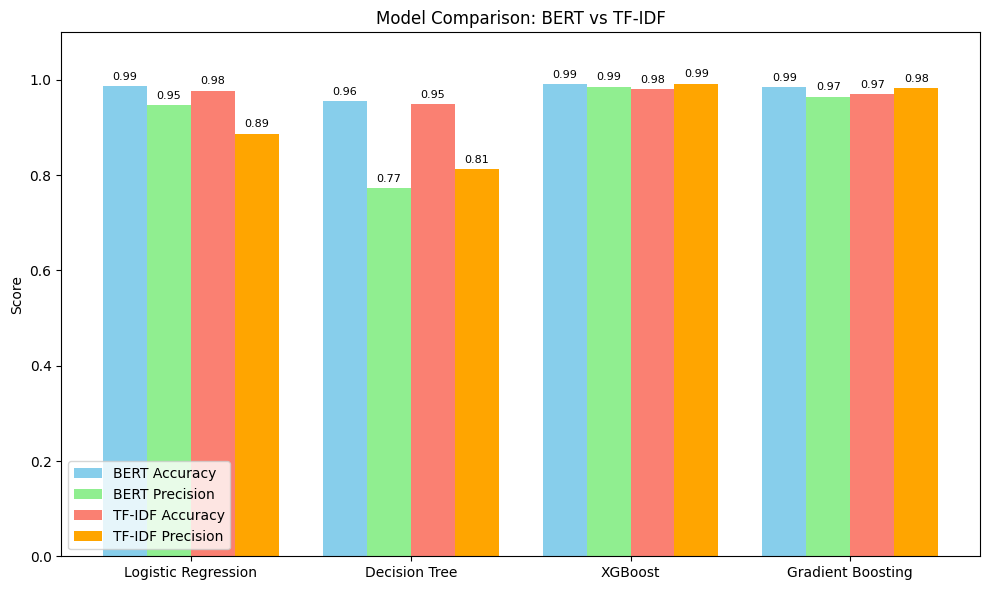

In [13]:
# Convert to DataFrames
bert_df = pd.DataFrame(results_bert).T
tfidf_df = pd.DataFrame(results).T

# Combine for plotting
metrics = ['accuracy', 'precision']
models = bert_df.index

x = np.arange(len(models))  # label locations
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric and method
rects1 = ax.bar(x - width, bert_df['accuracy'], width, label='BERT Accuracy', color='skyblue')
rects2 = ax.bar(x, bert_df['precision'], width, label='BERT Precision', color='lightgreen')
rects3 = ax.bar(x + width, tfidf_df['accuracy'], width, label='TF-IDF Accuracy', color='salmon')
rects4 = ax.bar(x + 2*width, tfidf_df['precision'], width, label='TF-IDF Precision', color='orange')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Model Comparison: BERT vs TF-IDF')
ax.set_xticks(x + width/2)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

for rects in [rects1, rects2, rects3, rects4]:
    add_labels(rects)

plt.tight_layout()
plt.show()